In [5]:
import os
import pandas as pd
import json
import glob


In [7]:
os.getcwd()

'/Users/tdentry/repos/vonage/Vonage_v4_server_SDK_apps'

In [6]:
os.listdir('webhooks')

['iOS26_call_screening',
 'event_CON-992227b2-22e7-4ccc-9a55-9c18c6a47c30.json',
 'event_CON-42005110-05bf-4a19-9ce3-9418e38133dc.json',
 'event_CON-25cb5dd3-9a3b-4823-b1ff-b9d63139835f.json',
 'event_CON-5d5881c6-058c-49d6-a09b-dd18001fde90.json',
 'NRC_Testing',
 'event_CON-83802e44-738a-4f09-8fd0-4c9a03337a09.json',
 'dtmf_input_CON-25cb5dd3-9a3b-4823-b1ff-b9d63139835f.json',
 'dtmf_input_CON-42005110-05bf-4a19-9ce3-9418e38133dc.json',
 'Vonage_Testing']

In [49]:
import pandas as pd
import json
import glob
import os
from datetime import datetime

def read_json_file(filepath):
    records = {}
    common_fields = ['from', 'to', 'uuid', 'conversation_uuid', 'direction']

    with open(filepath, 'r') as file:
        content = file.read()
        json_strings = content.strip().split('}\n{')

        for i, json_str in enumerate(json_strings):
            if i > 0:
                json_str = '{' + json_str
            if i < len(json_strings) - 1:
                json_str = json_str + '}'

            try:
                record = json.loads(json_str)
                conv_id = record['conversation_uuid']

                # Initialize record if first time seeing this conversation
                if conv_id not in records:
                    records[conv_id] = {field: record[field] for field in common_fields}
                    records[conv_id]['timestamps'] = {}
                    records[conv_id]['status_sequence'] = []
                    records[conv_id]['sub_states'] = []
                    # Initialize detection fields
                    records[conv_id]['detection_timestamp'] = None
                    records[conv_id]['detection_type'] = None

                # Add timestamp with associated status
                status = record.get('status')
                if status:
                    records[conv_id]['timestamps'][status] = record['timestamp']
                    records[conv_id]['status_sequence'].append(status)
                    
                    # Capture machine/human detection ONLY on first occurrence
                    if status == 'machine' and records[conv_id]['detection_type'] is None:
                        records[conv_id]['detection_timestamp'] = record['timestamp']
                        records[conv_id]['detection_type'] = 'machine'
                    elif status == 'human' and records[conv_id]['detection_type'] is None:
                        records[conv_id]['detection_timestamp'] = record['timestamp']
                        records[conv_id]['detection_type'] = 'human'

                # Add sub_state if present
                if 'sub_state' in record:
                    records[conv_id]['sub_states'].append(record['sub_state'])

                # Add any unique fields from completion record
                if status == 'completed':
                    unique_fields = ['end_time', 'network', 'duration', 'disconnected_by',
                                     'start_time', 'rate', 'price']
                    for field in unique_fields:
                        if field in record:
                            records[conv_id][field] = record[field]

            except json.JSONDecodeError:
                continue

    return records

def calculate_detection_intervals(all_records):
    """Calculate detection intervals after all records are loaded"""
    for conv_id, record in all_records.items():
        answered_time = record['timestamps'].get('answered')
        detection_time = record.get('detection_timestamp')
        
        if answered_time and detection_time:
            try:
                # Convert timestamps to datetime objects for calculation
                answered_dt = datetime.fromisoformat(answered_time.replace('Z', '+00:00'))
                detection_dt = datetime.fromisoformat(detection_time.replace('Z', '+00:00'))
                
                # Calculate interval in seconds
                interval = (detection_dt - answered_dt).total_seconds()
                record['detection_interval_seconds'] = interval
                
            except (ValueError, TypeError) as e:
                print(f"Error calculating interval for {conv_id}: {e}")
                record['detection_interval_seconds'] = None
        else:
            record['detection_interval_seconds'] = None
    
    return all_records

def read_webhooks_from_directories(base_path, directories):
    '''Read webhook files from multiple directories and combine them'''
    all_records = {}

    for directory in directories:
        directory_path = os.path.join(base_path, directory)

        # Check if directory exists
        if not os.path.exists(directory_path):
            print(f'Warning: Directory {directory_path} does not exist... skipping.')
            continue

        # Find all json files in this directory
        json_files = glob.glob(os.path.join(directory_path, '*.json'))
        if not json_files:
            print(f"No json files found in '{directory_path}'")
            continue

        print(f"Processing {len(json_files)} json files from '{directory_path}'")

        # Process each file in the directory
        for file_path in json_files:
            try:
                records = read_json_file(file_path)
                print(f"  - File '{file_path}' loaded {len(records)} conversations")

                # Add source directory info for each record for tracing purposes
                for conv_id, record in records.items():
                    record['source_directory'] = directory
                    record['source_file'] = os.path.basename(file_path)

                # Merge with all_records (handling duplicates if needed)
                for conv_id, record in records.items():
                    if conv_id in all_records:
                        print(f"Warning: Duplicate conversation_uuid '{conv_id}' found in '{directory}'")
                        continue
                    all_records[conv_id] = record

            except Exception as e:
                print(f"Error processing file '{file_path}': {e}")
                continue

    return all_records

# Usage - Add debugging
base_path = './webhooks'
directories = ['NRC_Testing', 'Vonage_Testing']

print(f"Looking for directories in: {os.path.abspath(base_path)}")
print(f"Directories to process: {directories}")

# Read the webhook files from above dirs
all_records = read_webhooks_from_directories(base_path, directories)

# Calculate detection intervals
all_records = calculate_detection_intervals(all_records)

print(f"\nTotal conversations loaded: {len(all_records)}")

# Check if we actually got records BEFORE creating DataFrame
if not all_records:
    print("No records were loaded! Check your directory paths and file contents.")
    print("Cannot create DataFrame without data.")
else:
    print("Sample record keys:", list(all_records.keys())[:3])
    print("Sample record structure:", list(all_records.values())[0].keys())
    
    df = pd.DataFrame.from_dict(all_records, orient='index')
    df = df.reset_index(drop=True)  # Creates default numeric index

    print(f'Total records loaded: {len(df)}')
    print(f'Records by source directory:')
    print(df['source_directory'].value_counts())
    
    # Show detection interval statistics
    print(f"\nDetection Analysis:")
    print(f"Records with detection: {df['detection_type'].notna().sum()}")
    print(f"Detection types: {df['detection_type'].value_counts()}")
    print(f"Average detection interval: {df['detection_interval_seconds'].mean():.2f} seconds")
    
    print("\nColumns:", df.columns.tolist())
    # print("\nFirst few records:")
    #print(df[['conversation_uuid', 'detection_type', 'detection_interval_seconds', 'source_directory']].head())

Looking for directories in: /Users/tdentry/repos/vonage/Vonage_v4_server_SDK_apps/webhooks
Directories to process: ['NRC_Testing', 'Vonage_Testing']
Processing 13 json files from './webhooks/NRC_Testing'
  - File './webhooks/NRC_Testing/NRC_event_CON-b1eadf46-c807-4a9b-a0b4-41c9dacfdd54.json' loaded 1 conversations
  - File './webhooks/NRC_Testing/NRC_event_CON-1dae9aac-f685-4de4-a190-5fc347b68758.json' loaded 1 conversations
  - File './webhooks/NRC_Testing/NRC_event_CON-d1464750-f69d-46e9-b30c-52d3fcef9611.json' loaded 1 conversations
  - File './webhooks/NRC_Testing/NRC_event_CON-629fcd25-bea6-401a-9297-b22ad7d556f2.json' loaded 1 conversations
  - File './webhooks/NRC_Testing/NRC_event_CON-bfd5dbe1-85c6-4169-a72f-c996a8038c41.json' loaded 1 conversations
  - File './webhooks/NRC_Testing/NRC_event_CON-29542269-4875-4ea6-8890-49b6526687b8.json' loaded 1 conversations
  - File './webhooks/NRC_Testing/NRC_event_CON-e76a62d1-17d1-40cc-b819-5d3434bb7dbc.json' loaded 1 conversations
  - F

In [46]:
# df.head()

In [47]:
# df.tail()

In [48]:
# df.iloc[0]

In [50]:
# Just the columns you need to debug
df.loc[17, ['conversation_uuid', 'status_sequence', 'timestamps', 'detection_type', 'detection_interval_seconds']]

conversation_uuid                      CON-1adb788a-6b40-4a33-bc23-80f56cd4a809
status_sequence               [started, ringing, answered, machine, machine,...
timestamps                    {'started': '2025-07-02T16:44:11.962Z', 'ringi...
detection_type                                                          machine
detection_interval_seconds                                                5.203
Name: 17, dtype: object

In [51]:
df[df['conversation_uuid'] == "CON-0c40de3a-edc7-421e-8b93-92ba0013ce24"]

,from,to,uuid,conversation_uuid,direction,timestamps,status_sequence,sub_states,detection_timestamp,detection_type,end_time,network,duration,disconnected_by,start_time,rate,price,source_directory,source_file,detection_interval_seconds
13,12014293841,19726722984,22341542-4129-4bcf-a488-f44f2c2afce8,CON-0c40de3a-edc7-421e-8b93-92ba0013ce24,outbound,"{'ringing': '2025-07-02T16:30:40.269Z', 'start...","[ringing, started, answered, human, completed]",[],2025-07-02T16:30:48.232Z,human,2025-07-02T16:31:11.000Z,310090,28,user,2025-07-02T16:30:43.000Z,0.01314000,0.00613200,Vonage_Testing,Vonage_event_CON-0c40de3a-edc7-421e-8b93-92ba0...,4.81


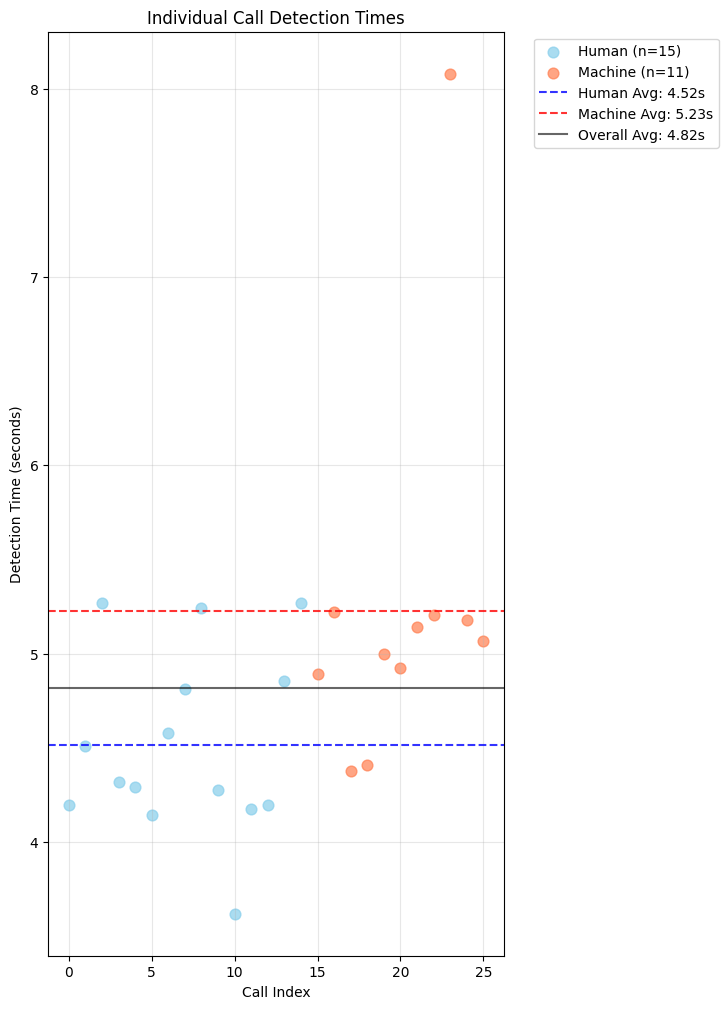

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# plot style
plt.style.use('default')
sns.set_palette('husl')

# set filter to only records with detection intervals
df_detected = df[df['detection_interval_seconds'].notna()].copy()

# create the plot
fig = plt.figure(figsize=(20,12))
# main chart will be detection times by conversation
ax1 = plt.subplot(2, 3, (1, 4))

# scatter plot with different colors for human vs machine
human_data = df_detected[df_detected['detection_type'] == 'human']
machine_data = df_detected[df_detected['detection_type'] == 'machine']

# plot points
if len(human_data) > 0:
    ax1.scatter(range(len(human_data)), human_data['detection_interval_seconds'], 
               alpha=0.7, s=60, label=f'Human (n={len(human_data)})', color='skyblue')

if len(machine_data) > 0:
    ax1.scatter(range(len(human_data), len(human_data) + len(machine_data)), 
               machine_data['detection_interval_seconds'],
               alpha=0.7, s=60, label=f'Machine (n={len(machine_data)})', color='coral')

# Add average lines
if len(human_data) > 0:
    human_avg = human_data['detection_interval_seconds'].mean()
    ax1.axhline(y=human_avg, color='blue', linestyle='--', alpha=0.8, 
               label=f'Human Avg: {human_avg:.2f}s')

if len(machine_data) > 0:
    machine_avg = machine_data['detection_interval_seconds'].mean()
    ax1.axhline(y=machine_avg, color='red', linestyle='--', alpha=0.8,
               label=f'Machine Avg: {machine_avg:.2f}s')

overall_avg = df_detected['detection_interval_seconds'].mean()
ax1.axhline(y=overall_avg, color='black', linestyle='-', alpha=0.6,
           label=f'Overall Avg: {overall_avg:.2f}s')

ax1.set_xlabel('Call Index')
ax1.set_ylabel('Detection Time (seconds)')
ax1.set_title('Individual Call Detection Times')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)